In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [12]:
import zipfile


with zipfile.ZipFile("C:\\Users\\ASUS\\Captcha\\archive.zip", 'r') as zip_ref:
    zip_ref.extractall("archive")




In [3]:
from pathlib import Path
from PIL import Image

def convert_jpg_to_png(input_folder, output_folder):
    
    Path(output_folder).mkdir(parents=True, exist_ok=True)

    
    jpg_images = Path(input_folder).glob("*.jpg")

    for jpg_image in jpg_images:
       
        with Image.open(jpg_image) as img:
           
            png_image = Path(output_folder) / (jpg_image.stem + ".png")

           
            img.save(png_image, format="PNG")

if __name__ == "__main__":
  
    input_folder_path = r"C:\\Users\\ASUS\\Captcha\\archive"  
    output_folder_path = r"C:\\Users\\ASUS\\Captcha\\image"  

   
    convert_jpg_to_png(input_folder_path, output_folder_path)

    print("Conversion completed.")


Conversion completed.


In [26]:
from pathlib import Path
import os

data_dir = Path("C:\\Users\\ASUS\\Captcha\\image")


images = sorted(list(map(str, list(data_dir.glob("*.png")))))


if not images:
    print("Error: No PNG images found in the specified directory.")
   

labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)


batch_size = 40


img_width = 150
img_height = 40

downsample_factor = 4


max_length = max([len(label) for label in labels]) if labels else 0



Number of images found:  113062
Number of labels found:  113062
Number of unique characters:  60
Characters present:  {'L', '2', 'a', 't', '4', 'T', 'D', 'e', 'l', 'K', 'f', 'G', 'V', 'A', 'Q', 'i', 's', 'd', 'x', '6', 'O', 'Z', 'W', '5', 'E', '1', 'u', 'm', 'c', 'v', 'U', 'r', 'b', 'z', 'g', 'I', 'y', 'C', 'w', 'F', 'X', '9', 'k', 'Y', 'p', 'N', 'j', '8', 'q', 'H', '3', 'S', 'P', 'h', '7', 'M', 'R', 'n', 'J', 'B'}


In [27]:



char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)


num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)


def split_data(images, labels, train_size=0.9, shuffle=True):
   
    size = len(images)
 
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
   
    train_samples = int(size * train_size)
  
    x_train, y_train = images[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


x_train, x_valid, y_train, y_valid = split_data(np.array(images), np.array(labels))


def encode_single_sample(img_path, label):
 
    img = tf.io.read_file(img_path)

    img = tf.io.decode_png(img, channels=1)
  
    img = tf.image.convert_image_dtype(img, tf.float32)

    img = tf.image.resize(img, [img_height, img_width])
   
    img = tf.transpose(img, perm=[1, 0, 2])
   
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
   
    return {"image": img, "label": label}

In [28]:

train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (
    train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
validation_dataset = (
    validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
    .batch(batch_size)
    .prefetch(buffer_size=tf.data.AUTOTUNE)
)

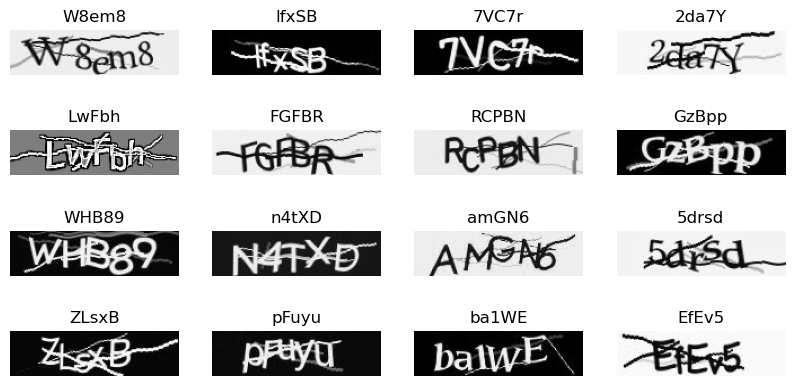

In [30]:
_, ax = plt.subplots(4, 4, figsize=(10, 5))
for batch in train_dataset.take(1):
    images = batch["image"]
    labels = batch["label"]
    for i in range(16):
        img = (images[i] * 255).numpy().astype("uint8")
        label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
        ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
        ax[i // 4, i % 4].set_title(label)
        ax[i // 4, i % 4].axis("off")
plt.show()

In [31]:
def ctc_batch_cost(y_true, y_pred, input_length, label_length):
    label_length = tf.cast(tf.squeeze(label_length, axis=-1), tf.int32)
    input_length = tf.cast(tf.squeeze(input_length, axis=-1), tf.int32)
    sparse_labels = tf.cast(ctc_label_dense_to_sparse(y_true, label_length), tf.int32)

    y_pred = tf.math.log(tf.transpose(y_pred, perm=[1, 0, 2]) + keras.backend.epsilon())

    return tf.expand_dims(
        tf.compat.v1.nn.ctc_loss(
            inputs=y_pred, labels=sparse_labels, sequence_length=input_length
        ),
        1,
    )


def ctc_label_dense_to_sparse(labels, label_lengths):
    label_shape = tf.shape(labels)
    num_batches_tns = tf.stack([label_shape[0]])
    max_num_labels_tns = tf.stack([label_shape[1]])

    def range_less_than(old_input, current_input):
        return tf.expand_dims(tf.range(tf.shape(old_input)[1]), 0) < tf.fill(
            max_num_labels_tns, current_input
        )

    init = tf.cast(tf.fill([1, label_shape[1]], 0), tf.bool)
    dense_mask = tf.compat.v1.scan(
        range_less_than, label_lengths, initializer=init, parallel_iterations=1
    )
    dense_mask = dense_mask[:, 0, :]

    label_array = tf.reshape(
        tf.tile(tf.range(0, label_shape[1]), num_batches_tns), label_shape
    )
    label_ind = tf.compat.v1.boolean_mask(label_array, dense_mask)

    batch_array = tf.transpose(
        tf.reshape(
            tf.tile(tf.range(0, label_shape[0]), max_num_labels_tns),
            tf.reverse(label_shape, [0]),
        )
    )
    batch_ind = tf.compat.v1.boolean_mask(batch_array, dense_mask)
    indices = tf.transpose(
        tf.reshape(tf.concat([batch_ind, label_ind], axis=0), [2, -1])
    )

    vals_sparse = tf.compat.v1.gather_nd(labels, indices)

    return tf.SparseTensor(
        tf.cast(indices, tf.int64), vals_sparse, tf.cast(label_shape, tf.int64)
    )


class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = ctc_batch_cost

    def call(self, y_true, y_pred):
        
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        
        return y_pred


def build_model():
   
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # CTC layer
    output = CTCLayer(name="ctc_loss")(labels, x)

  
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
   
    model.compile(optimizer=opt)
    return model



model = build_model()
model.summary()

Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 150, 40, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 40, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 75, 20, 32)   0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 75, 20, 64)   18496       ['pool1[0][0]']       

In [40]:
epochs = 5
early_stopping_patience = 10

early_stopping = keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=early_stopping_patience, restore_best_weights=True
)

history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    callbacks=[early_stopping],
)

Epoch 1/5
2544/2544 [==============================] - 989s 389ms/step - loss: 6.7745 - val_loss: 5.3976
Epoch 2/5
2544/2544 [==============================] - 1000s 393ms/step - loss: 6.2766 - val_loss: 4.9692
Epoch 3/5
2544/2544 [==============================] - 1472s 579ms/step - loss: 5.8643 - val_loss: 4.5824
Epoch 4/5
2544/2544 [==============================] - 1003s 394ms/step - loss: 5.5302 - val_loss: 4.3966
Epoch 5/5
2544/2544 [==============================] - 1395s 548ms/step - loss: 5.2543 - val_loss: 4.1030


In [ ]:
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()


def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
   
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text



for batch in validation_dataset.take(1):
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 4, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")
plt.show()
     